## Setup

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model

## Helper Functions

In [2]:
def format_data(data):
    y1 = data.pop("Y1")
    y2 = data.pop("Y2")
    return np.array(y1), np.array(y2)

def norm(x):
    return (x - train_stats["mean"]) / train_stats["std"]

def plot_predictions(y_true, y_pred, title=''):
    sns.regplot(y_true, y_pred)
    plt.title(title)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")    
    plt.axis("equal")
    plt.axis("square")
    plt.show()
    
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(hist[metric_name], color="green", label=metric_name)
    plt.plot(hist["val_" + metric_name], color="red", label="val_" + metric_name)
    plt.show()

In [3]:
# Read data
URI = "./data/ENB2012_data.xlsx"
data = pd.read_excel(URI)
# data = data.sample(frac=1).reset_index(drop=True)

# split data into training and test samples
train_data, test_data = train_test_split(data, test_size=0.2)

# create a descriptive analysis table
train_stats = train_data.describe().T
train_stats.drop(["Y1", "Y2"], inplace=True)

# format data
train_Y = format_data(train_data)
test_Y = format_data(test_data)

# normalize data
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

## Creating Model's Architecture

In [4]:
input_layer = Input(len(train_data.columns))

dense_1 = Dense(units="128", activation=tf.nn.relu)(input_layer)
dense_2 = Dense(units="128", activation=tf.nn.relu)(dense_1)

y1_output = Dense(units="1", name="y1_output")(dense_2)
dense_3 = Dense(units="64", activation=tf.nn.relu)(dense_2)

y2_output = Dense(units="1", name="y2_output")(dense_3)

model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

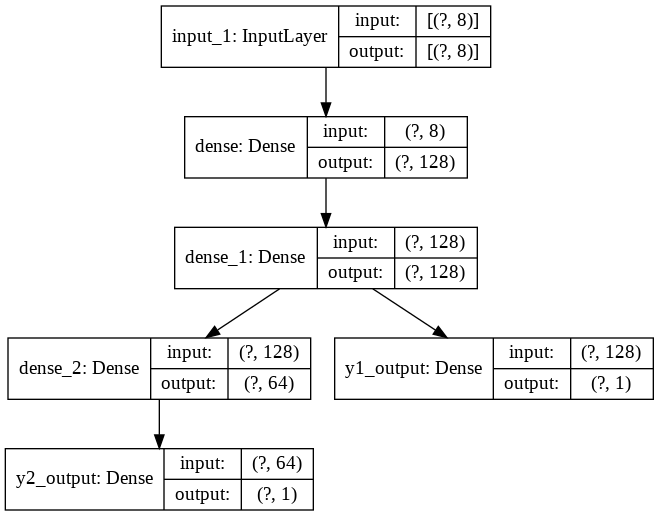

In [5]:
plot_model(model, show_shapes=True)

## Configure parameters

In [6]:
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001),
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [8]:
history = model.fit(normed_train_data, train_Y,
                    epochs=700, batch_size=10, 
                    validation_data=[normed_test_data, test_Y])

Train on 614 samples, validate on 154 samples
Epoch 1/700
614/614 [==============================] - 1s 1ms/sample - loss: 240.9780 - y1_output_loss: 117.3514 - y2_output_loss: 121.5904 - y1_output_root_mean_squared_error: 10.8794 - y2_output_root_mean_squared_error: 11.0732 - val_loss: 40.1178 - val_y1_output_loss: 10.3968 - val_y2_output_loss: 30.4642 - val_y1_output_root_mean_squared_error: 3.2223 - val_y2_output_root_mean_squared_error: 5.4530
Epoch 2/700
614/614 [==============================] - 0s 150us/sample - loss: 31.1512 - y1_output_loss: 12.5103 - y2_output_loss: 18.3592 - y1_output_root_mean_squared_error: 3.5539 - y2_output_root_mean_squared_error: 4.3036 - val_loss: 18.0638 - val_y1_output_loss: 7.6406 - val_y2_output_loss: 9.9937 - val_y1_output_root_mean_squared_error: 2.8050 - val_y2_output_root_mean_squared_error: 3.1931
Epoch 3/700
614/614 [==============================] - 0s 140us/sample - loss: 33.8836 - y1_output_loss: 11.8638 - y2_output_loss: 21.7389 - y1_out

In [9]:
# Test the model and print loss and mse for both outputs
model.evaluate(normed_test_data, test_Y)

154/154 [==============================] - 0s 49us/sample - loss: 1.0178 - y1_output_loss: 0.3233 - y2_output_loss: 0.6991 - y1_output_root_mean_squared_error: 0.5675 - y2_output_root_mean_squared_error: 0.8341


[1.0177852968116858, 0.3233244, 0.6991, 0.56753016, 0.83408326]

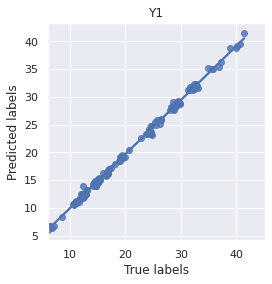

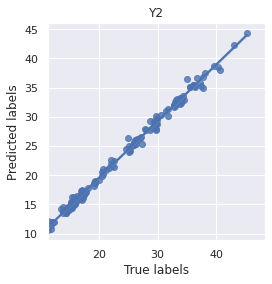

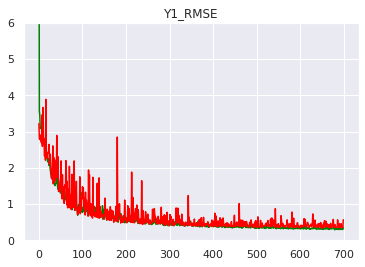

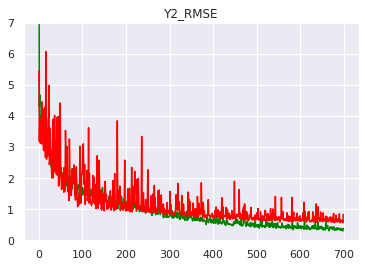

In [10]:
# Plot the loss and mse
Y_pred = model.predict(normed_test_data)

hist = pd.DataFrame(history.history)
plot_predictions(test_Y[0], Y_pred[0], title='Y1')
plot_predictions(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name="y1_output_root_mean_squared_error", title="Y1_RMSE", ylim=6)
plot_metrics(metric_name="y2_output_root_mean_squared_error", title="Y2_RMSE", ylim=7)